In [1]:
import pandas as pd
import numpy as np

import sklearn.cross_validation

import skimage.exposure
import skimage.transform

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import lasagne
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled)


In [11]:
# Read training set info and make train/val split
SEED = 2

np.random.seed(SEED)

df = pd.read_csv('./data/train.csv')

N_CLASSES = len(df.whaleID.unique())
CLASS_IX = {ID: i for i, ID in enumerate(df.whaleID.unique())}

#train_ix, val_ix = sklearn.cross_validation.train_test_split(range(len(df)))

train_ix = range(len(df))

In [3]:
# function to load and preprocess image with random distortions

# expects input images cropped to face region, 384x384
DATA_DIR = './data/traincrop384'

def prep_image(fn, seed=None):
    if seed is None:
        seed = np.random.randint(4294967295)
    rng = np.random.RandomState(seed)

    im = plt.imread('{}/{}'.format(DATA_DIR, fn))

    # random adjustment of gamma
    im = skimage.exposure.adjust_gamma(im, rng.uniform(0.5, 1.5))

    # random crop of each border
    x1, x2, y1, y2 = rng.randint(1, 48, 4)
    im = im[y1:-y2, x1:-x2]
    
    # scale cropped region to square 320x320
    im = skimage.transform.resize(im, (320, 320))
    
    im = im - 0.5

    # convert axes to bc01
    im = np.transpose(im, (2, 0, 1))[np.newaxis]

    return lasagne.utils.floatX(im)

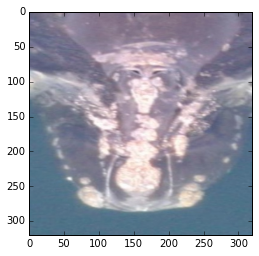

In [4]:
im = prep_image(df.ix[0, 0])
plt.imshow(im[0].T + 0.5)

In [5]:
# generate a minibatch of augmented images and labels

def batch(ix, batch_size, seed=None):
    if seed is None:
        seed = np.random.randint(4294967295)
    rng = np.random.RandomState(seed)
    seeds = rng.randint(0, 4294967295, batch_size)
    
    image_ix = rng.choice(ix, batch_size)
    fns = (df.ix[i].Image for i in image_ix)
    images = [prep_image(fn, seed) for fn, seed in zip(fns, seeds)]
    images = np.concatenate(images)
    
    labels = np.array([CLASS_IX[df.whaleID[i]] for i in image_ix]).astype('int32')
    return images, labels

In [6]:
# Context manager to generate batches in the background via a process pool

import uuid, os, pickle, hashlib
from multiprocessing import Process, Queue

class BatchGenCM:
    def __init__(self, batch_fn, ix, batch_size, seed=None, num_workers=8):
        self.batch_fn = batch_fn
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.ix = ix
        if seed is None:
            seed = np.random.randint(4294967295)
        self.seed = str(seed)
        self.id = uuid.uuid4()
        
    def __enter__(self):
        self.jobq = Queue(maxsize=self.num_workers)
        self.doneq = Queue()
        self.processes = []
        self.current_batch = 0
        self.finished_batches = []
        
        def f(batch_fn, ix, batch_size):
            while True:
                n = self.jobq.get()
                if n is None:
                    break
                seed = int(hashlib.md5(self.seed + str(n)).hexdigest(), 16) % 4294967295
                batch = batch_fn(ix, batch_size, seed)
                pickle.dump(batch, open('/run/shm/{}-{}'.format(self.id, n), 'w'), protocol=pickle.HIGHEST_PROTOCOL)
                self.doneq.put(n)
        
        for i in range(self.num_workers):
            self.jobq.put(i)

            p = Process(target=f, args=(self.batch_fn, self.ix, self.batch_size))
            self.processes.append(p)
            p.start()        

        return self
    
    def __iter__(self):
        return self
    
    def next(self):
        n = self.current_batch
        while n not in self.finished_batches:
            i = self.doneq.get()
            self.finished_batches.append(i)
        
        fn = '/run/shm/{}-{}'.format(self.id, n)
        batch = pickle.load(open(fn))
        os.system('rm {}'.format(fn))

        self.jobq.put(n + self.num_workers)        
        self.current_batch += 1
        return batch
            
    def __exit__(self, exc_type, exc_value, traceback):
        for _ in range(self.num_workers):
            self.jobq.put(None)
        for process in self.processes:
            process.join()
        while not self.doneq.empty():
            _ = next(self)

In [3]:
# Neon's dropout works a bit differently than Lasagne, matching it just in case it matters

from lasagne.layers import Layer
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from lasagne.random import get_rng

class NeonDropoutLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(NeonDropoutLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic:
            return (1 - self.p) * input
        else:
            retain_prob = 1 - self.p

            # use nonsymbolic shape for dropout mask if possible
            input_shape = self.input_shape
            if any(s is None for s in input_shape):
                input_shape = input.shape

            return input * self._srng.binomial(input_shape, p=retain_prob,
                                               dtype=theano.config.floatX)

In [4]:
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as Conv
#from lasagne.layers.dnn import Pool2DDNNLayer as Pool
from lasagne.layers.corrmm import Conv2DMMLayer as Conv
from lasagne.layers import Pool2DLayer as Pool

from lasagne.layers import batch_norm

from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform
from lasagne.utils import floatX

def build_model(batch_size, input_width, input_height):
    net = {}
    activation = lasagne.nonlinearities.rectify

    nfilt = 32

    l = InputLayer((batch_size, 3, input_width, input_height))
    net['input'] = l
    l = batch_norm(Conv(l, nfilt, 2, stride=2, nonlinearity=rectify, W=GlorotUniform(gain='relu')))

    for _ in range(5):
        if nfilt >= 1024:
            nfilt = 1024
        l = batch_norm(Conv(l, nfilt, 3, stride=1, pad=0, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
        l = Pool(l, 2, stride=2)
        nfilt *= 2
    l = batch_norm(Conv(l, nfilt, 3,stride=1, pad=0, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
        
    l = NeonDropoutLayer(l, p=0.8)
    l = DenseLayer(l, num_units=447, nonlinearity=softmax, W=GlorotUniform(gain='relu'))
    net['output'] = l
    return net

In [14]:
net = build_model(32, 320, 320)

In [15]:
X = T.tensor4()
y = T.ivector()

prob = lasagne.layers.get_output(net['output'], X)
loss = T.mean(lasagne.objectives.categorical_crossentropy(prob, y))
acc = T.mean(lasagne.objectives.categorical_accuracy(prob, y))

test_prob = lasagne.layers.get_output(net['output'], X, deterministic=True)
test_loss = T.mean(lasagne.objectives.categorical_crossentropy(test_prob, y))
test_acc = T.mean(lasagne.objectives.categorical_accuracy(test_prob, y))

params = lasagne.layers.get_all_params(net['output'], trainable=True)

updates = lasagne.updates.adadelta(loss, params, learning_rate=1.0, rho=0.9)

In [16]:
f_prob = theano.function([X], test_prob)
f_train = theano.function([X, y], [loss, acc], updates=updates)
f_val = theano.function([X, y], [test_loss, test_acc])

In [17]:
# After 300 epochs, should be around 1.9-2.0 val loss
BATCH_SIZE = 32
N_BATCH = len(train_ix) / BATCH_SIZE
N_VAL_BATCH = 10

SEED = 2

lasagne.random.set_rng(np.random.RandomState(SEED))
with BatchGenCM(batch, train_ix, 32, seed=SEED) as train_bg:
    for epoch in range(300):
        loss_train = 0
        for _ in range(N_BATCH):
            loss_batch, _ = f_train(*next(train_bg))
            loss_train += loss_batch
        print('epoch {:03} - tr: {:.04f}'.format(epoch, loss_train/N_BATCH))

epoch 000 - tr: 6.0808
epoch 001 - tr: 5.9473
epoch 002 - tr: 5.7825
epoch 003 - tr: 5.6124
epoch 004 - tr: 5.4957
epoch 005 - tr: 5.3707
epoch 006 - tr: 5.2470
epoch 007 - tr: 5.0906
epoch 008 - tr: 4.9368
epoch 009 - tr: 4.7733
epoch 010 - tr: 4.5965
epoch 011 - tr: 4.4667
epoch 012 - tr: 4.3002
epoch 013 - tr: 4.0329
epoch 014 - tr: 3.8999
epoch 015 - tr: 3.6787
epoch 016 - tr: 3.5138
epoch 017 - tr: 3.3353
epoch 018 - tr: 3.1926
epoch 019 - tr: 3.0015
epoch 020 - tr: 2.8687
epoch 021 - tr: 2.6509
epoch 022 - tr: 2.4784
epoch 023 - tr: 2.3429
epoch 024 - tr: 2.3083
epoch 025 - tr: 2.0976
epoch 026 - tr: 1.9419
epoch 027 - tr: 1.8325
epoch 028 - tr: 1.7319
epoch 029 - tr: 1.6763
epoch 030 - tr: 1.5409
epoch 031 - tr: 1.4535
epoch 032 - tr: 1.3535
epoch 033 - tr: 1.2386
epoch 034 - tr: 1.2499
epoch 035 - tr: 1.1545
epoch 036 - tr: 1.0879
epoch 037 - tr: 1.0497
epoch 038 - tr: 0.9817
epoch 039 - tr: 0.9396
epoch 040 - tr: 0.9029
epoch 041 - tr: 0.8645
epoch 042 - tr: 0.7942
epoch 043 -

In [5]:
#pvs = lasagne.layers.get_all_param_values(net['output'])
#pickle.dump(pvs, open('./cls_seed2_0103_300_epochs.pkl','w'))
pvs = pickle.load(open('./cls_seed2_0103_300_epochs.pkl'))

In [15]:
net = build_model(None, 320, 320)
lasagne.layers.set_all_param_values(net['output'], pvs)


X = T.tensor4()
y = T.ivector()

test_prob = lasagne.layers.get_output(net['output'], X, deterministic=True)
f_prob = theano.function([X], test_prob)


In [30]:
def prep_test_image(fn, seed):
    rng = np.random.RandomState(seed)
    im = plt.imread('./data/testcrops_detcrop/{}'.format(fn))
    im = im/255.
    if min(im.shape[:2]) < 384:
        im = skimage.transform.resize(im, (384, 384))
    im = skimage.exposure.adjust_gamma(im, rng.uniform(0.5, 1.5))
    x1, x2, y1, y2 = rng.randint(1, 48, 4)
    im = im[y1:-y2, x1:-x2]
    im = skimage.transform.resize(im, (320, 320))
    
    im = im - 0.5

    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)

    return lasagne.utils.floatX(im[np.newaxis])

In [9]:
import joblib

In [ ]:
df = pd.read_csv('data/sample_submission.csv')

rng = np.random.RandomState(SEED)

p = []
for i in range(len(df)):
    if i % 200 == 0:
        print i
    seeds = rng.randint(0, 4294967295, 64)
    im = np.concatenate(joblib.Parallel(n_jobs=8)(joblib.delayed(prep_test_image)(df.Image[i], s) for s in seeds))
    p.append(f_prob(im).mean(0))
p = np.array(p)

ix_map = np.array([CLASS_IX[i] for i in df.columns[1:]])
df.ix[:, 1:] = p[:, ix_map]
df.to_csv('submission_01062016_1.csv', index=False)

0


In [21]:
import gzip
import sklearn.metrics
import sklearn.preprocessing

In [31]:
df1 = pd.read_csv('submission_01062016_1.csv')
#df0 = pd.read_csv('submission_01032016_1.csv')
df0 = pd.read_csv('/home/eben/Downloads/Shize_v47.csv')

In [32]:
y = np.array(df0.ix[:,1:]).argmax(1)
ohe = sklearn.preprocessing.OneHotEncoder(n_values=447, sparse=False)
y = ohe.fit_transform(y[:,np.newaxis])
                      
p = np.array(df1.sort('Image').ix[:,1:])
#p = np.array(df1.ix[:,1:])

In [33]:
sklearn.metrics.log_loss(y, p)

2.0634019969137389

In [18]:
i

94

In [24]:
fn = df.Image[i]

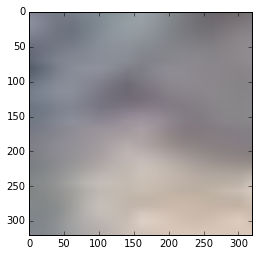

In [33]:
plt.imshow(prep_test_image(fn, 1)[0].T +0.5)

In [27]:
im = plt.imread('./data/testcrops_detcrop/{}'.format(fn))

In [29]:
im.shape

(17, 31, 3)